# ODE solver performance battle

The point of this jupyter notebook is to look at how some of the available ODE solvers perform for our particular transmon simulation. Up until now, we used the QuTip python library, which abstract away the use of these solvers. This makes the code simpler and easy to read, but hides the heart of the problem, which in essence is to numerically solve a differential equation. For our system, this is the Schrödinger equation:
$$
i\hbar\frac{\partial}{\partial t}\ket{\psi} - \hat{H(t)}\ket{\psi}
$$
This can be solved with the usual tools, namely any type of Runge-Kutta method. QuTip has a few options under the hood for time-dependent Hamiltonians, they are all adaptive solvers. Meaning that they estimate the **local truncation error (LTE)**—the error introduced in a single step—and compare it to the user's requested **absolute tolerance (atol)** and **relative tolerance (rtol)**.

### 1. Embedded Runge-Kutta Methods
* **Methods:** `'dop853'`, `'tsit5'`, `'vern7'`, `'vern9'`

These methods use an "embedded pair" or "FSAL" (First Same As Last) strategy.

* **How it works:** In a single step, the algorithm uses its set of coefficients (the Butcher tableau) to compute two different solutions:
    1.  A high-order solution: $y_{n+1}$ (e.g., 8th-order for `'dop853'`)
    2.  A lower-order solution: $\hat{y}_{n+1}$ (e.g., 5th-order for `'dop853'`)

* **Error Estimation:** The difference between these two solutions, $E = ||y_{n+1} - \hat{y}_{n+1}||$, provides a highly efficient and accurate estimate of the local error.

* **Step Control:**
    1.  **If $E > \text{Tolerance}$:** The estimated error is too high. The step is **rejected**. The step size $h$ is significantly reduced (e.g., $h_{\text{new}} < h_{\text{old}}$), and the step is re-computed with the new, smaller $h$.
    2.  **If $E \le \text{Tolerance}$:** The error is acceptable. The step is **accepted**, and the high-order solution $y_{n+1}$ is used. The solver then calculates an optimal $h_{\text{new}}$ for the *next* step, often increasing it slightly to improve efficiency, based on the formula $h_{\text{new}} = h_{\text{old}} \times (\text{Tolerance} / E)^{1/p}$, where $p$ is the order of the error estimator.

### 2. Linear Multistep Methods
* **Methods:** `'adams'`, `'bdf'`

These methods use a **predictor-corrector** mechanism to estimate the error.

* **How it works:**
    1.  **Predict:** An *explicit* formula (e.g., Adams-Bashforth) uses previous steps ($y_n, y_{n-1}, \dots$) to predict a "guess" for the next step, $y_{n+1}^{(p)}$.
    2.  **Correct:** An *implicit* formula (e.g., Adams-Moulton) uses the predicted value $y_{n+1}^{(p)}$ to solve for a more accurate, final value, $y_{n+1}^{(c)}$.

* **Error Estimation:** The difference between the predicted guess and the final corrected value, $E = ||y_{n+1}^{(c)} - y_{n+1}^{(p)}||$, serves as a good estimate of the local error.

* **Step Control:**
    * The logic is the same as for Runge-Kutta: if $E$ is too large, the step is rejected and $h$ is reduced. If $E$ is acceptable, the step is taken, and $h$ is adjusted for the next step.
    * **Adaptive Order:** A key feature of these methods is that they are also **adaptive-order**. If the error is consistently very low, they may *increase their order* (e.g., from a 3-step to a 4-step BDF) to take larger, more efficient steps. If the error is hard to control, they may decrease their order.

### 3. Special Cases
* **`'lsoda'`**
    This solver **does not have its own step-size logic**. It is a "meta-solver" that simply uses the step-size control logic of whichever method it is currently running:
    * If the problem is non-stiff, it runs `'adams'` and uses its predictor-corrector error estimation.
    * If it detects stiffness, it switches to `'bdf'` and uses its predictor-corrector error estimation.

* **`'diag'`**
    This method has **no step-size control**. It is not an integrator. It calculates the exact analytical solution $y_k(t) = y_k(0) e^{\lambda_k t}$ for every time $t$ specified in the user's `tlist`. The "steps" are just the intervals in the `tlist` you provide.

* **`'krylov'`**
    This method's error control is **not based on the time step $h$**.
    * Its accuracy is controlled by the **dimension ($m$) of the Krylov subspace**. The error is the difference between the true matrix exponential $e^{Lh}y$ and its approximation $V_m e^{H_m h} V_m^T y$.
    * The time step $h$ itself is **fixed**. It is either the interval between points in your `tlist` ($\Delta t = t_{n+1} - t_n$) or, if you set `options.nsteps`, a smaller, fixed internal step ($h = \Delta t / \text{nsteps}$). It does not adapt $h$ based on a temporal error estimate.

In [13]:
import numpy as np
import time
import os
from scipy.sparse import (
    identity as sparse_identity,
    diags as sparse_diags,
    kron as sparse_kron,
    csc_matrix,
    eye as sparse_eye
)
from scipy.sparse.linalg import expm as sparse_expm
from scipy.integrate import solve_ivp, RK45
from scipy.integrate._ivp.base import OdeSolver
from functools import reduce # Needed for sparse.kron reduction
import sys
from pathlib import Path
# Add the project root directory to Python path
notebook_path = Path().absolute()  # Gets the current notebook directory
project_root = notebook_path.parent  # Goes up one level to project root
sys.path.append(str(project_root))
from utils.funcs import load_params
import matplotlib.pyplot as plt

### Operator functions

In [14]:
# --- SciPy/NumPy Operator Definitions ---

def sparse_destroy(dim):
    """Creates a sparse destruction operator."""
    if dim <= 0:
        raise ValueError("Dimension must be > 0")
    if dim == 1:
        return csc_matrix((1, 1), dtype=np.complex128)
    data = np.sqrt(np.arange(1, dim, dtype=np.complex128))
    offsets = [1]
    # FIX: Wrap 'data' in a list to match the list 'offsets'
    return sparse_diags([data], offsets, shape=(dim, dim), format='csc')

def sparse_num(dim):
    """Creates a sparse number operator."""
    if dim <= 0:
        raise ValueError("Dimension must be > 0")
    if dim == 1:
        return csc_matrix((1, 1), dtype=np.complex128)
    data = np.arange(dim, dtype=np.complex128)
    offsets = [0]
    # FIX: Wrap 'data' in a list to match the list 'offsets'
    return sparse_diags([data], offsets, shape=(dim, dim), format='csc')

def get_sparse_op(op, site, dims):
    """
    Creates a full-system sparse operator from a local operator
    using sparse.kron.
    """
    op_list = [sparse_identity(d, dtype=np.complex128, format='csc') for d in dims]
    op_list[site] = op
    return reduce(sparse_kron, op_list)

def propagator_ode_real(t, y_real, H0, H1, W, nu_delta, D):
    """
    The ODE function for the propagator U(t), compatible with solve_ivp.
    It evolves dU/dt = -i * H(t) * U(t)
    
    y_real = [U_flat_real, U_flat_imag] (size 2 * D*D)
    """
    D_sq = D * D
    # Reconstruct the complex flattened vector
    U_flat_complex = y_real[:D_sq] + 1j * y_real[D_sq:]
    
    # Reshape into a D x D matrix
    # We use 'F' (Fortran) order to match the flattening,
    # which is standard for quantum mechanics state vectors vs operators.
    U = U_flat_complex.reshape((D, D), order='F')
    
    # Calculate H(t)
    H_t = H0 + H1 * (W * np.cos(nu_delta * t))
    
    # Calculate dU/dt = -i * H(t) * U
    # H_t is (D, D), U is (D, D). Use matrix multiplication
    dU_dt_complex = -1j * (H_t @ U)
    
    # Flatten the complex derivative
    dU_dt_flat = dU_dt_complex.flatten(order='F')
    
    # Split back into real and imaginary parts
    return np.concatenate([dU_dt_flat.real, dU_dt_flat.imag])

def build_H(params):

    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    eta = float(params['eta'])
    phiq = float(params['phiq'])
    phia = eval(str(params['phia']))
    J = eval(str(params['J']))
    nu = eval(str(params['nu']))
    delta = eval(str(params['delta']))
    de = float(params['de']) * delta
    wq = eval(str(params['wq']))
    EJ = eval(str(params['EJ']))

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]
    D_total = np.prod(dims)

    En = []
    for i in range(N):
        En.append(wq + i * de)
        En.append(nu)
    En = np.array(En)

    # --- Local Operators (Sparse) ---

    a_t = sparse_destroy(n_max_transmon)
    a_t_dag = a_t.conj().T.tocsc() 
    n_t = sparse_num(n_max_transmon)
    x_t = a_t_dag + a_t           

    a_r = sparse_destroy(n_max_resonator)
    a_r_dag = a_r.conj().T.tocsc() 
    n_r = sparse_num(n_max_resonator)
    x_r = a_r_dag + a_r           

    print(f"Total Hilbert space dimension: {D_total}")

    # --- Build Hamiltonian (Sparse) ---
    print("Building sparse H0...")
    # On-site energies
    H0 = csc_matrix((D_total, D_total), dtype=np.complex128)
    for i in range(2 * N):
        if i % 2 == 0:  # Transmon site
            H0 += En[i] * get_sparse_op(n_t, i, dims)
        else:  # Resonator site
            H0 += En[i] * get_sparse_op(n_r, i, dims)

    # EJ term: -0.5*EJ*(phi^2 + cos(phi))
    phi_squared_sum = csc_matrix((D_total, D_total), dtype=np.complex128)
    cos_phi_sum = csc_matrix((D_total, D_total), dtype=np.complex128)

    for i in range(N):
        print(f"Building phi term for site {i}...")
        # phi_op for the i-th Transmon-Resonator pair
        phi_op = (
            phiq * get_sparse_op(x_t, 2 * i, dims) + 
            phia * get_sparse_op(x_r, 2 * i + 1, dims)
        )
        
        # Contribution to the sum of phi^2 terms
        phi_squared_sum += phi_op * phi_op
        
        # Contribution to the sum of cos(phi) terms
        # This is the computationally heavy step
        print(f"Calculating matrix exponential for site {i}...")
        U_phi = sparse_expm(-1j * phi_op)
        cos_phi_sum += 0.5 * (U_phi + U_phi.conj().T)
        print(f"Done with site {i}.")

    H0 += EJ * (0.5 * phi_squared_sum + cos_phi_sum)

    # J coupling term
    for i in range(N - 1):
        H0 += J * get_sparse_op(x_t, 2 * i, dims) * get_sparse_op(x_t, 2 * i + 2, dims)

    print("Building sparse H1...")
    # Time-dependent part of Hamiltonian
    H1 = csc_matrix((D_total, D_total), dtype=np.complex128)
    for i in range(N):
        H1 += get_sparse_op(x_t, 2 * i, dims)

    return H0, H1

def initial_state(params):

    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]

    # --- Build Initial State (NumPy) ---
    psi_list = []
    for i in range(2 * N):
        dim_i = dims[i] # Get the correct dimension for the site
        state_vec = np.zeros(dim_i, dtype=np.complex128)
        if i == 0:
            state_vec[1] = 1.0 # Transmon 1 is |1>
        else:
            state_vec[0] = 1.0 # All others are |0>
        psi_list.append(state_vec)

    # Use reduce with np.kron for the state vector
    psi0_vec = reduce(np.kron, psi_list)

    return psi0_vec

def get_number_ops(params):
    
    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]

    n_t = sparse_num(n_max_transmon)
    n_r = sparse_num(n_max_resonator)

    # --- Build Observables (Sparse) ---
    number_ops = []
    for i in range(2 * N):
        if i % 2 == 0:
            number_ops.append(get_sparse_op(n_t, i, dims))
        else:
            number_ops.append(get_sparse_op(n_r, i, dims))

    return number_ops

def plot_sim(njt, tlist):
    # --- Create Plot ---
    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(njt.shape[1]):
        if i % 2 == 0:  # Transmon site
            label_base = f'Transmon_{i//2 + 1}'
            plot_label = f'<n> Transmon {i//2 + 1}'
        else:  # Resonator site
            label_base = f'Resonator_{i//2 + 1}'
            plot_label = f'<n> Resonator {i//2 + 1}'

        expect_values = njt[:,i]
        ax.plot(tlist, expect_values, label=plot_label)

    # --- Configure and Show Plot ---
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Population")
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()

### Set up the problem

Construct the time-independent (H0) and time-dependent (H1) Hamiltonian parts as SciPy sparse matrices. In the code, the lab frame Hamiltonian  for a single transmon-resonator pair is 
$$
\hat{H} = \omega_a \hat{a}^\dagger \hat{a} + \omega_q \hat{q}^\dagger\hat{q} - E_J \bigg[\cos(\hat{\varphi}) +\frac{\hat{\varphi}^2}{2}\bigg] + \Omega (\hat{q} + \hat{q}^\dagger) \cos(\omega_d t)
$$
where 

* $\hat{a}^\dagger$ and $\hat{a}$: Are the creation and annihilation operators.

* $\omega_q$​: Is the angular frequency of the linear resonator mode.

* $\hat{q}^\dagger$ and $\hat{q}$​: Are the creation and annihilation operators for the qubit (the transmon)

* $\omega_a$​: Is the angular frequency of the uncoupled transmon qubit transition ($\ket{0} \rightarrow \ket{1}$).

* $E_{J}$​: Is the Josephson energy, which characterizes the non-linearity of the transmon qubit. The term $E_J \cos(\hat{\varphi}) + \frac{\hat{\varphi}^2}{2}$ represents the non-linear potential of the transmon junction.

* $\varphi$: Is the phase operator across the Josephson junction, related to the qubit operators ($\hat{q}^\dagger$ and $\hat{q}$).

* $\cos(\omega_d t)$: Represents an external, classical driving field applied to the transmon qubit, where Ω is the drive amplitude (Rabi frequency) and ωd​ is the drive frequency. This term is responsible for coherent operations.

Since there are several sites (transmon-resonator pairs) in the simulation, the coupling between them is expressed as 
$$
\hat{H}_{\text{coupling}} = J \sum_{i=1}^{N-1} \hat{\varphi}_{q,i} \hat{\varphi}_{q,i+1}
$$
where the he transmon position operator, corresponding to \texttt{x\_t} in the code, is:
$$
\hat{\varphi}_{q} \equiv \hat{x}_t = \hat{a}_q + \hat{a}_q^\dagger
$$
where $\hat{a}_q$ and $\hat{a}_q^\dagger$ are the annihilation and creation operators for the transmon mode.


In [15]:

# --- Evaluate parameters ---
params = load_params('example.json')

# --- System hamiltonian ---
H0, H1 = build_H(params)

# --- Initial state vector ---
psi0_vec = initial_state(params)

# --- Number operators ---
number_ops = get_number_ops(params)

Total Hilbert space dimension: 256
Building sparse H0...
Building phi term for site 0...
Calculating matrix exponential for site 0...
Done with site 0.
Building phi term for site 1...
Calculating matrix exponential for site 1...
Done with site 1.
Building sparse H1...


### 1. Handmade numpy for loop


Starting unitary propagation
Unitary evolution for a single period took 23.11 seconds
CustomRK4 solver finished, used 1663 steps
Shape of y0real is (131072,)
Last state has dims (131072,)
Flat U operator has dims (65536,)
Unitary operator has shape (256, 256)
Calculating expectation values...

Total ODE solver time: 26.75 seconds


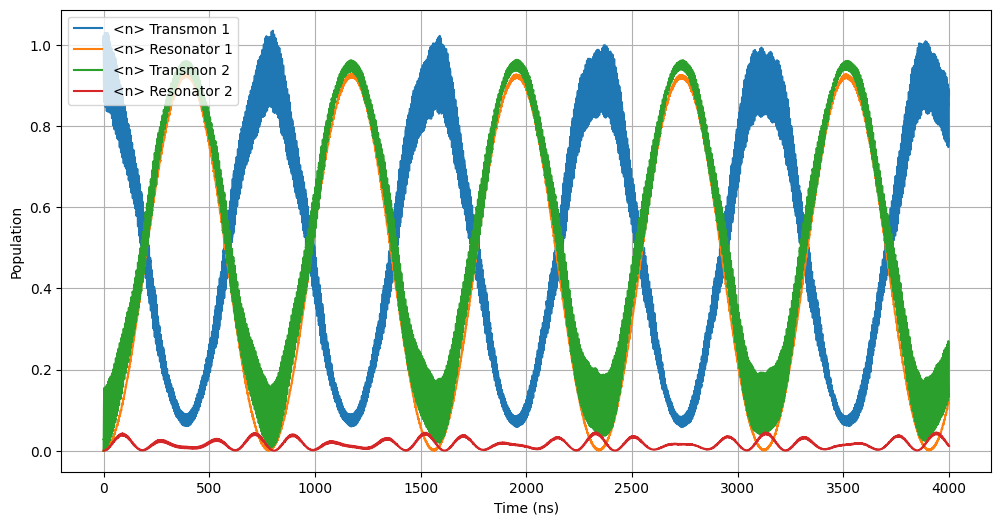

In [16]:
# Simulation settings
sim_length = params['sim_length']
usteps = params['usteps']
N = params['N']
n_max_transmon = params['n_max_transmon']
n_max_resonator = params['n_max_resonator']

# Physical constants
eta = float(params['eta'])
nu = eval(str(params['nu']))
delta = eval(str(params['delta']))
de = float(params['de']) * delta
wq = eval(str(params['wq']))

W = eta * (wq**2 - (nu - delta)**2) / (2 * wq)
nu_delta = nu - delta
period = 2 * np.pi / nu_delta

# Number of steps for one period propagation
usteps = int(params['usteps'])

# --- Set up Time List for one period ---
tlist_one_period = np.linspace(0, period, usteps)

# Calculate the step size used for evaluation points
U_dt = tlist_one_period[1] - tlist_one_period[0]
params['U_dt'] = U_dt

# --- Set up stroboscopic time list for full evolution ---
tUsteps = int(sim_length / period)
tlist = np.linspace(0, tUsteps * period, tUsteps + 1)
params['sim_dt'] = period

# --- System Definition ---
dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]
D_total = np.prod(dims)
D_sq = D_total * D_total
UT = sparse_identity(D_total, dtype=np.complex128, format='csc')


# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
y0_real = np.concatenate([I_flat.real, I_flat.imag])

# Record time taken
start_time = time.time()

# Run 4th order Runge Kutta with fixed step size
print('Starting unitary propagation')
y0_current = y0_real.copy()
for i in np.arange(usteps - 1):
    
    k1 = propagator_ode_real(i*U_dt, y0_current, H0, H1, W, nu_delta, D_total)
    k2 = propagator_ode_real((i+1/2)*U_dt, y0_current+U_dt*k1/2, H0, H1, W, nu_delta, D_total)
    k3 = propagator_ode_real((i+1/2)*U_dt, y0_current+U_dt*k2/2, H0, H1, W, nu_delta, D_total)
    k4 = propagator_ode_real((i+1)*U_dt, y0_current+U_dt*k3, H0, H1, W, nu_delta, D_total)

    y0_current += U_dt*(k1+2*k2+2*k3+k4)/6

u_time = time.time() - start_time
print(f"Unitary evolution for a single period took {u_time:.2f} seconds")
print(f"CustomRK4 solver finished, used {usteps} steps")
# Reconstruct U from y0_real
print(f"Shape of y0real is {y0_current.shape}")
y_final = y0_current
print(f"Last state has dims {y_final.shape}")
U_flat = y_final[:D_sq] + 1j * y_final[D_sq:]
print(f"Flat U operator has dims {U_flat.shape}")
U = U_flat.reshape((D_total, D_total), order='F')
print(f"Unitary operator has shape {U.shape}")

# Run the time evolution for sim_length
print("Calculating expectation values...")
njt = np.zeros((len(tlist), 2 * N))
psi_t = psi0_vec # Start with the initial state vector

for i, t in enumerate(tlist):
    # Measure expectation values
    for j in range(2 * N):
        op_j = number_ops[j]
        # <psi|O|psi> = (psi_conj.T) @ O @ psi
        exp_val = np.conj(psi_t) @ (op_j @ psi_t)
        njt[i, j] = exp_val.real
    
    # Evolve state for the next step
    psi_t = U @ psi_t

total_time = time.time() - start_time
print(f"\nTotal ODE solver time: {total_time:.2f} seconds")

# Show results 
plot_sim(njt, tlist)

### 2. Monkey patch scipy's custom RK4 solver
Monkey patching is a way of modifying existing python libraries on the go. Here I am importing the OdeSolver class from scipy and modifying it so that I can spcify the step size myself, essentially doing what the code above is doing. In theory, scipy's implementation should be faster, as it should have smaller overhead than the for loop employed above.

In [17]:
from scipy.integrate._ivp.base import OdeSolver

class CustomRK4(OdeSolver):
    """
    A custom Runge-Kutta 4 solver with a fixed step size (h), implemented 
    as a subclass of SciPy's internal OdeSolver base class.
    
    This solver is selected by setting 'solver_method': 'CUSTOM_RK4'.
    The fixed step size h is derived from the 'usteps' parameter.
    """
    
    order = 4 # Order of the integration method
    
    def __init__(self, fun, t0, y0, t_bound, vectorized, **extraneous):
        # Initialize base class (handles fun, t0, y0, t_bound, vectorized)
        h = extraneous.pop('max_step', np.inf)         
        # 'max_step' passed by solve_ivp will be used here to convey the fixed step size 'h'
        if h == np.inf:
            raise ValueError("CustomRK4 requires a finite step size (h). Check 'usteps' calculation.")
        
        super().__init__(fun, t0, y0, t_bound, vectorized, **extraneous)
        self.h = h
        
    def _step_impl(self):
        """Performs one fixed-size RK4 step."""
        t, y = self.t, self.y
        h = self.h
        
        # Check if the step would go beyond the boundary
        if t + h >= self.t_bound:
            h = self.t_bound - t
            if h <= 1e-15: # Time step is effectively zero
                self.status = 'finished'
                return False, False # Stop integration
        
        # RK4 coefficients calculation
        try:
            k1 = self.fun(t, y)
            k2 = self.fun(t + h / 2, y + h * k1 / 2)
            k3 = self.fun(t + h / 2, y + h * k2 / 2)
            k4 = self.fun(t + h, y + h * k3)
        except Exception as e:
            self.status = 'failed'
            self.message = f"Error during RHS evaluation in CustomRK4: {e}"
            return False, False

        # Update y using RK4 formula
        self.y += h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        self.t += h
        
        # Check if we reached the boundary (or very close)
        if self.t >= self.t_bound - 1e-15:
            self.status = 'finished'

        # Success=True, Error_estimate=False (fixed step)
        return True, False 

    def _dense_output_impl(self):
        # Dense output is not implemented or required for this use case.
        return None

### Test the custom RK4
Now let's run the simulation using the custom class

Starting CustomRK4 solver 
CustomRK4 solver finished.
CustomRK4 solver finished, used 1663 steps
Unitary evolution for a single period took 22.70 seconds
Calculating expectation values...

Total ODE solver time: 26.26 seconds


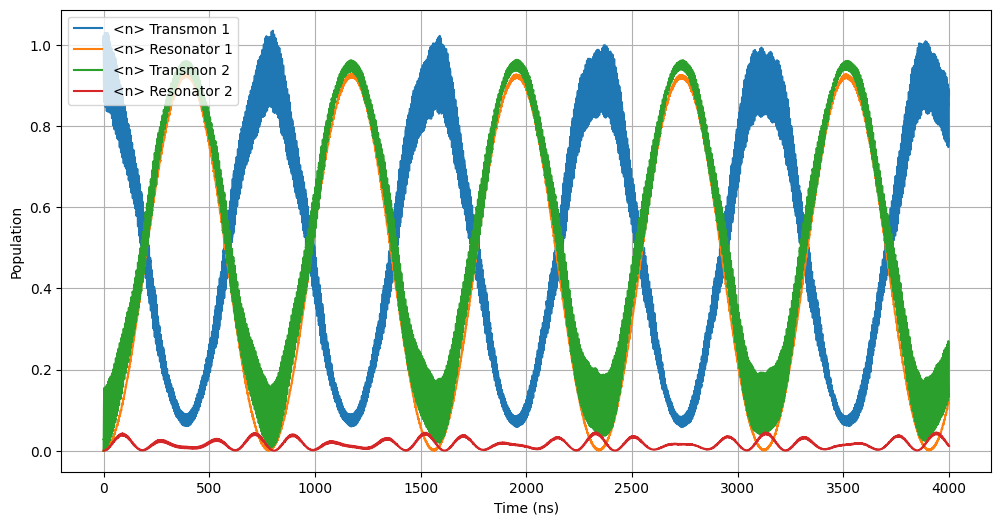

In [18]:
# ODE arguments
ode_args = (H0, H1, W, nu_delta, D_total)

# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
y0_real = np.concatenate([I_flat.real, I_flat.imag])

# This takes the expected (t, y) and passes them to your function *with* the extra args
fun_wrapped = lambda t, y: propagator_ode_real(t, y, *ode_args)

# Dictionary to store results
solver_results = {}

start_time = time.time()
print(f"Starting CustomRK4 solver ")
sol_U_custom = solve_ivp(
    propagator_ode_real,
    t_span=[tlist_one_period[0], tlist_one_period[-1]],
    y0=y0_real,
    args=ode_args,
    method=CustomRK4,
    max_step=U_dt,
    dense_output=False
)
custom_time = time.time() - start_time
print(f"CustomRK4 solver finished.")
print(f"CustomRK4 solver finished, used {len(sol_U_custom.t)} steps")
print(f"Unitary evolution for a single period took {custom_time:.2f} seconds")

# Reconstruct U from CustomRK4
y_final_custom = sol_U_custom.y[:, -1]
U_flat_custom = y_final_custom[:D_sq] + 1j * y_final_custom[D_sq:]
U_custom = U_flat_custom.reshape((D_total, D_total), order='F')
solver_results['CustomRK4'] = {'time': custom_time, 'U': U_custom, 'steps': len(sol_U_custom.t)}

# --- Process Results (Iterative Evolution) ---
print("Calculating expectation values...")
njt = np.zeros((len(tlist), 2 * N))
psi_t = psi0_vec # Start with the initial state vector

for i, t in enumerate(tlist):
    # Measure expectation values
    for j in range(2 * N):
        op_j = number_ops[j]
        # <psi|O|psi> = (psi_conj.T) @ O @ psi
        exp_val = np.conj(psi_t) @ (op_j @ psi_t)
        njt[i, j] = exp_val.real
    
    # Evolve state for the next step
    psi_t = U_custom @ psi_t

total_time = time.time() - start_time
print(f"\nTotal ODE solver time: {total_time:.2f} seconds")

# Show results 
plot_sim(njt, tlist)


### 3. Scipy's apadtive step RK45
In adaptive solvers like SciPy's RK45 (Dormand-Prince method), the step size (h) is dynamic, adjusting automatically to maintain the simulation's accuracy. This accuracy is controlled by two user-defined parameters: atol (Absolute Tolerance) and rtol (Relative Tolerance).

  *  $atol$ (Absolute Tolerance): This sets the lower bound for allowable error. It is dominant when the solution values (y) are very small (close to zero). Essentially, it says, "The error should never exceed this fixed value, regardless of how small the solution gets."

  *  $rtol$ (Relative Tolerance): This scales the allowable error based on the magnitude of the solution. It is dominant when y is large. It says, "The error should be no more than this fraction (percentage) of the current solution value."

How Step Size is Determined: In every step, the solver computes two estimates of the solution: a 4th-order prediction (y4th​) and a 5th-order prediction (y5th​). The difference between them provides an estimate of the Local Truncation Error (LTE). The solver compares this LTE against a combined tolerance threshold (Tolcombined​):
$Tol_{combined​}=atol+rtol⋅∣y∣$

   * If $LTE≤Tol_{combined}$​: The step is accepted. If the error is very low, the solver may increase the step size for the next iteration to speed up the simulation.

   * If $LTE>Tol_{combined}$​: The error is too high. The step is rejected, and the solver retries with a smaller step size (h) to reduce the error below the threshold.

Starting adaptive RK45 solver...
Adaptive RK45 solver finished, used 390 steps
Unitary evolution for a single period took 10.68 seconds
Calculating expectation values...

Total ODE solver time: 14.45 seconds


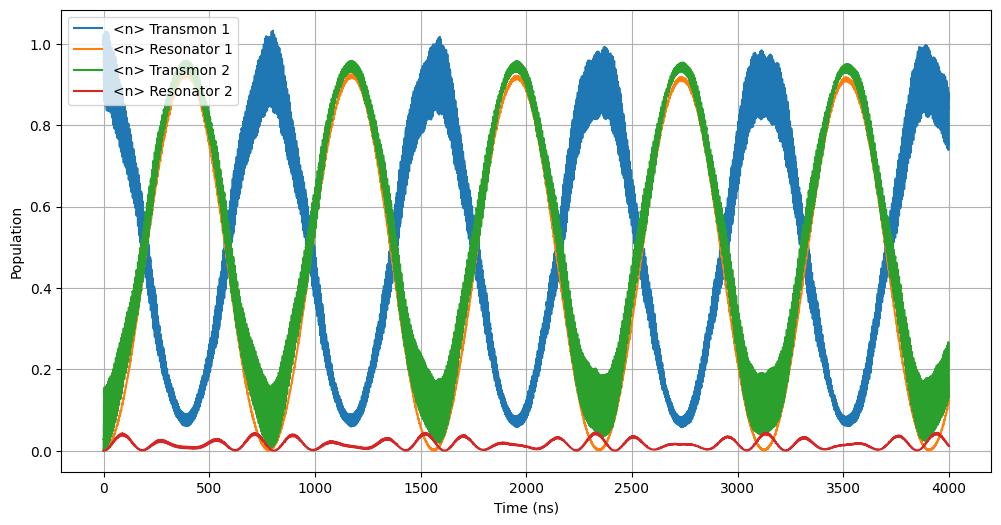

In [19]:
# Choose absolute and relative tolerance
rtol= 1e-7
atol=1e-9

# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
y0_real = np.concatenate([I_flat.real, I_flat.imag])

# ODE arguments
ode_args = (H0, H1, W, nu_delta, D_total)

# This takes the expected (t, y) and passes them to your function *with* the extra args
fun_wrapped = lambda t, y: propagator_ode_real(t, y, *ode_args)

# Dictionary to store results
solver_results = {}

start_time = time.time()
print(f"Starting adaptive RK45 solver...")
sol_U_rk45 = solve_ivp(
    fun_wrapped,
    t_span = (0,period),
    y0=y0_real,
    method='RK45',
    t_eval = None,
    first_step=None,
    max_step = 0.02,
    rtol=rtol,
    atol=atol,
    vectorized=True,
)
rk45_time = time.time() - start_time
print(f"Adaptive RK45 solver finished, used {len(sol_U_rk45.t)} steps")
print(f"Unitary evolution for a single period took {rk45_time:.2f} seconds")

# Reconstruct U from custom RK45
y_final_rk45 = sol_U_rk45.y[:, -1]
# y_final_rk45 = sol_U_rk45.y
U_flat_rk45 = y_final_rk45[:D_sq] + 1j * y_final_rk45[D_sq:]
U_rk45 = U_flat_rk45.reshape((D_total, D_total), order='F')
solver_results['RK45'] = {'time': rk45_time, 'U': U_rk45, 'steps': len(sol_U_rk45.t)}

# --- Process Results (Iterative Evolution) ---
print("Calculating expectation values...")
njt = np.zeros((len(tlist), 2 * N))
psi_t = psi0_vec # Start with the initial state vector

for i, t in enumerate(tlist):
    # Measure expectation values
    for j in range(2 * N):
        op_j = number_ops[j]
        # <psi|O|psi> = (psi_conj.T) @ O @ psi
        exp_val = np.conj(psi_t) @ (op_j @ psi_t)
        njt[i, j] = exp_val.real
    
    # Evolve state for the next step
    psi_t = U_rk45 @ psi_t

total_time = time.time() - start_time
print(f"\nTotal ODE solver time: {total_time:.2f} seconds")

# Show results 
plot_sim(njt, tlist)


### Comparison Tolerance vs Time step

Surprise! Surprise! Looks like by making the tolerance small enough, the adaptive solver is able to arrive at the same solution as our homemade Runge-Kutta for loop but with nearly a fourth of the steps required in the previous sections. We can now test for convergence by making the overall tolerance ever smaller, which is equivalent to taking smaller step sizes.


Calculating reference solution with tolerance: 1e-12
Reference calculation finished. Steps: 2552, Time: 60.77s
--------------------------------------------------
Starting convergence test loop...
Solving with rtol=atol=1e-03...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-04...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-05...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-06...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-07...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-08...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-09...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-10...
  -> Steps: 1662, Error: 6.21e-08
Solving with rtol=atol=1e-11...
  -> Steps: 1663, Error: 6.21e-08
Solving with rtol=atol=1e-12...
  -> Steps: 2552, Error: 0.00e+00
--------------------------------------------------
Convergence loop finished.
For a tolerance of 0.001 the error was 6.210528334188646e-08
For a

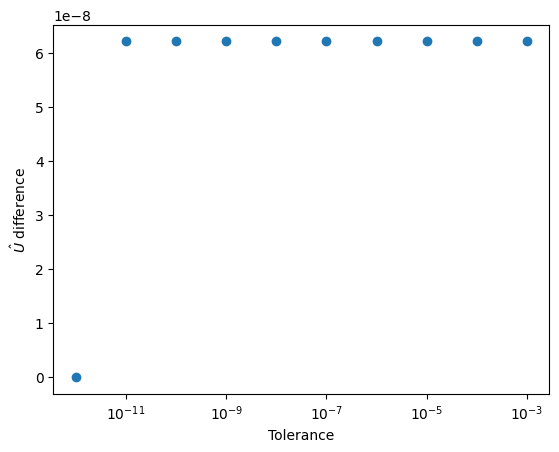

In [21]:
# 1. Define the range of tolerances (tau)
tau_list = np.logspace(-3, -12, 10) # e.g., [1e-6, 1e-7, ..., 1e-12]

# Lists to store results
step_counts = []
errors = []

# --- Step 2: Calculate the Reference Solution (Tightest Tolerance) ---
ref_tau = tau_list[-1]
print(f"Calculating reference solution with tolerance: {ref_tau:.0e}")

start_time = time.time()

sol_ref = solve_ivp(
    fun_wrapped,
    t_span=(0, period),
    y0=y0_real,
    method='RK45',
    t_eval=None,
    max_step=U_dt,
    rtol=ref_tau,
    atol=ref_tau,
    vectorized=True,
)
ref_time = time.time() - start_time

# Extract reference U: use the last column
y_ref = sol_ref.y[:, -1]
U_flat_ref = y_ref[:D_sq] + 1j * y_ref[D_sq:]
U_ref = U_flat_ref.reshape((D_total, D_total), order='F')

print(f"Reference calculation finished. Steps: {len(sol_ref.t) - 1}, Time: {ref_time:.2f}s")
print("-" * 50)

# --- Step 3 & 4: Loop and Solve for Convergence ---

print("Starting convergence test loop...")

for tau in tau_list:
    print(f"Solving with rtol=atol={tau:.0e}...")
    
    start_time = time.time()
    
    sol_i = solve_ivp(
        fun_wrapped,
        t_span=(0, period),
        y0=y0_real,
        method='RK45',
        t_eval=None,
        max_step=U_dt,
        rtol=tau,
        atol=tau,
        vectorized=True,
    )
    
    # Store step count
    steps_i = len(sol_i.t) - 1
    step_counts.append(steps_i)
    
    # Extract U_i
    y_i = sol_i.y[:, -1]
    U_flat_i = y_i[:D_sq] + 1j * y_i[D_sq:]
    U_i = U_flat_i.reshape((D_total, D_total), order='F')
    
    # Calculate error: Frobenius Norm of the difference (||U_i - U_ref||_F)
    diff = U_i - U_ref
    error_i = np.linalg.norm(diff)
    errors.append(error_i)

    print(f"  -> Steps: {steps_i}, Error: {error_i:.2e}")

print("-" * 50)
print("Convergence loop finished.")

# Display the error values
for idx, value in enumerate(errors):
    print(f"For a tolerance of {tau_list[idx]} the error was {errors[idx]}")

# Plot results
fig = plt.figure()
plt.scatter(tau_list, errors)
# The correct way to set the x-axis scale is on the main plot object:
plt.xscale('log') 
plt.xlabel('Tolerance')
plt.ylabel('$\hat{U}$ difference')
plt.show() # Added plt.show() to display the plot



This shows that the difference between the unitary operators does not really between tolerances of $10^{-3}$ down to around $10^{-10}$ (at least for this 'RK45' method). If we run the same test for the $10^{-11}$ to $10^{-12}$ range, we find:

Calculating reference solution with tolerance: 1e-12
Reference calculation finished. Steps: 2552, Time: 58.75s
--------------------------------------------------
Starting convergence test loop...
Solving with rtol=atol=1.000000e-11...
Solving with rtol=atol=8.858668e-12...
Solving with rtol=atol=7.847600e-12...
Solving with rtol=atol=6.951928e-12...
Solving with rtol=atol=6.158482e-12...
Solving with rtol=atol=5.455595e-12...
Solving with rtol=atol=4.832930e-12...
Solving with rtol=atol=4.281332e-12...
Solving with rtol=atol=3.792690e-12...
Solving with rtol=atol=3.359818e-12...
Solving with rtol=atol=2.976351e-12...
Solving with rtol=atol=2.636651e-12...
Solving with rtol=atol=2.335721e-12...
Solving with rtol=atol=2.069138e-12...
Solving with rtol=atol=1.832981e-12...
Solving with rtol=atol=1.623777e-12...
Solving with rtol=atol=1.438450e-12...
Solving with rtol=atol=1.274275e-12...
Solving with rtol=atol=1.128838e-12...
Solving with rtol=atol=1.000000e-12...
------------------------

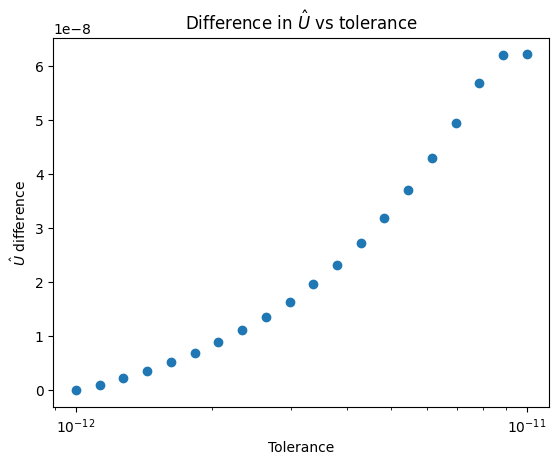

In [22]:
# 1. Define the range of tolerances (tau)
tau_list = np.logspace(-11, -12, 20) # e.g., [1e-6, 1e-7, ..., 1e-12]

# Lists to store results
step_counts = []
errors = []

# --- Step 2: Calculate the Reference Solution (Tightest Tolerance) ---
ref_tau = tau_list[-1]
print(f"Calculating reference solution with tolerance: {ref_tau:.0e}")

start_time = time.time()

sol_ref = solve_ivp(
    fun_wrapped,
    t_span=(0, period),
    y0=y0_real,
    method='RK45',
    t_eval=None,
    max_step=U_dt,
    rtol=ref_tau,
    atol=ref_tau,
    vectorized=True,
)
ref_time = time.time() - start_time

# Extract reference U: use the last column
y_ref = sol_ref.y[:, -1]
U_flat_ref = y_ref[:D_sq] + 1j * y_ref[D_sq:]
U_ref = U_flat_ref.reshape((D_total, D_total), order='F')

print(f"Reference calculation finished. Steps: {len(sol_ref.t) - 1}, Time: {ref_time:.2f}s")
print("-" * 50)

# --- Step 3 & 4: Loop and Solve for Convergence ---

print("Starting convergence test loop...")

for tau in tau_list:
    print(f"Solving with rtol=atol={tau:.6e}...")
    
    start_time = time.time()
    
    sol_i = solve_ivp(
        fun_wrapped,
        t_span=(0, period),
        y0=y0_real,
        method='RK45',
        t_eval=None,
        max_step=U_dt,
        rtol=tau,
        atol=tau,
        vectorized=True,
    )
    
    # Store step count
    steps_i = len(sol_i.t) - 1
    step_counts.append(steps_i)
    
    # Extract U_i
    y_i = sol_i.y[:, -1]
    U_flat_i = y_i[:D_sq] + 1j * y_i[D_sq:]
    U_i = U_flat_i.reshape((D_total, D_total), order='F')
    
    # Calculate error: Frobenius Norm of the difference (||U_i - U_ref||_F)
    diff = U_i - U_ref
    error_i = np.linalg.norm(diff)
    errors.append(error_i)

print("-" * 50)
print("Convergence loop finished.")
# Display the error values
for idx, value in enumerate(errors):
    print(f"For a tolerance of {tau_list[idx]} the error was {errors[idx]}")

# Plot results
fig = plt.figure()
plt.scatter(tau_list, errors)
# The correct way to set the x-axis scale is on the main plot object:
plt.xscale('log') 
plt.xlabel('Tolerance')
plt.ylabel('$\hat{U}$ difference')
plt.title('Difference in $\hat{U}$ vs tolerance')
plt.show() # Added plt.show() to display the plot


### Changing the timestep

Having obtained some sort of convergence as we decreased the tolerance for the adaptive step size method. We should be able to obtain a similar plot by decreasing the step size in the custom made solver that fixes the step size.

Calculating reference solution with dt: 0.00001
Reference calculation finished. Steps: 13941, Time: 199.84s
--------------------------------------------------
Starting convergence test loop...
Solving with dt=1.000000e-05...
Solving with dt=1.060818e-05...
Solving with dt=1.125336e-05...
Solving with dt=1.193777e-05...
Solving with dt=1.266380e-05...
Solving with dt=1.343399e-05...
Solving with dt=1.425103e-05...
Solving with dt=1.511775e-05...
Solving with dt=1.603719e-05...
Solving with dt=1.701254e-05...
Solving with dt=1.804722e-05...
Solving with dt=1.914482e-05...
Solving with dt=2.030918e-05...
Solving with dt=2.154435e-05...
Solving with dt=2.285464e-05...
Solving with dt=2.424462e-05...
Solving with dt=2.571914e-05...
Solving with dt=2.728333e-05...
Solving with dt=2.894266e-05...
Solving with dt=3.070291e-05...
Solving with dt=3.257021e-05...
Solving with dt=3.455107e-05...
Solving with dt=3.665241e-05...
Solving with dt=3.888155e-05...
Solving with dt=4.124626e-05...
Solving

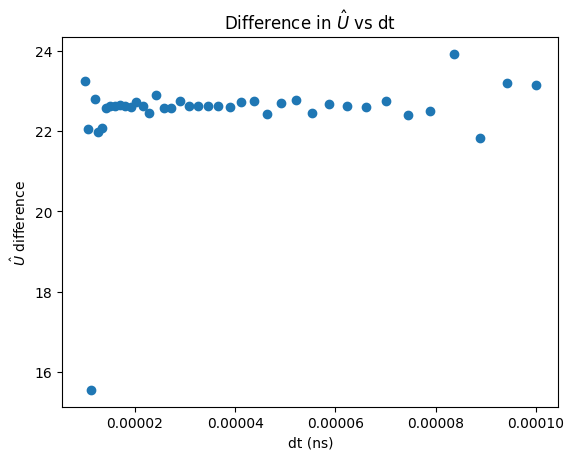

In [45]:

# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
y0_real = np.concatenate([I_flat.real, I_flat.imag])

# 1. Define the range of tolerances (tau)
dt_list = np.logspace(-5, -4, 40)

# Lists to store results
errors = []
step_counts = []

# --- Step 2: Calculate the Reference Solution (Tightest Tolerance) ---
ref_dt = dt_list[0]
print(f"Calculating reference solution with dt: {ref_dt:.5f}")

start_time = time.time()

sol_ref = solve_ivp(
    propagator_ode_real,
    t_span=(0, period),
    y0=y0_real,
    args=ode_args,
    method=CustomRK4,
    max_step=ref_dt,
    dense_output=False
)
ref_time = time.time() - start_time

# Extract reference U: use the last column
y_ref = sol_ref.y[:, -1]
U_flat_ref = y_ref[:D_sq] + 1j * y_ref[D_sq:]
U_ref = U_flat_ref.reshape((D_total, D_total), order='F')

print(f"Reference calculation finished. Steps: {len(sol_ref.t) - 1}, Time: {ref_time:.2f}s")
print("-" * 50)

print("Starting convergence test loop...")

for dt in dt_list:
    print(f"Solving with dt={dt:.6e}...")
    
    start_time = time.time()
    
    sol_i = solve_ivp(
        propagator_ode_real,
        t_span=(0, period),
        y0=y0_real,
        args=ode_args,
        method=CustomRK4,
        max_step=dt,
        dense_output=False
    )
    
    # Store step count
    steps_i = len(sol_i.t) - 1
    step_counts.append(steps_i)
    
    # Extract U_i
    y_i = sol_i.y[:, -1]
    U_flat_i = y_i[:D_sq] + 1j * y_i[D_sq:]
    U_i = U_flat_i.reshape((D_total, D_total), order='F')
    
    # Calculate error: Frobenius Norm of the difference (||U_i - U_ref||_F)
    diff = U_i - U_ref
    error_i = np.linalg.norm(diff)
    errors.append(error_i)

print("-" * 50)
print("Convergence loop finished.")
# Display the error values
# for idx, value in enumerate(errors):
#     print(f"For a dt of {dt_list[idx]} the error was {errors[idx]}")

# Plot results
fig = plt.figure()
plt.scatter(dt_list, errors)
# The correct way to set the x-axis scale is on the main plot object:
# plt.xscale('log') 
plt.xlabel('dt (ns)')
plt.ylabel('$\hat{U}$ difference')
plt.title('Difference in $\hat{U}$ vs dt')
plt.show() # Added plt.show() to display the plot


In [ ]:

# Define the time step range
dt_list = np.logspace(-5, -4, 40) # e.g., [1e-6, 1e-7, ..., 1e-12]
errors = []

# Calculate a reference U
dt_ref = 0.0001
# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
y0_real = np.concatenate([I_flat.real, I_flat.imag])

# Run 4th order Runge Kutta with fixed step size
print('Starting unitary propagation')
y0_current = y0_real.copy()
for i in np.arange(usteps - 1):
    
    k1 = propagator_ode_real(i*dt_ref, y0_current, H0, H1, W, nu_delta, D_total)
    k2 = propagator_ode_real((i+1/2)*dt_ref, y0_current+dt_ref*k1/2, H0, H1, W, nu_delta, D_total)
    k3 = propagator_ode_real((i+1/2)*dt_ref, y0_current+dt_ref*k2/2, H0, H1, W, nu_delta, D_total)
    k4 = propagator_ode_real((i+1)*dt_ref, y0_current+dt_ref*k3, H0, H1, W, nu_delta, D_total)

    y0_current += dt_ref*(k1+2*k2+2*k3+k4)/6

y_final = y0_current
U_flat = y_final[:D_sq] + 1j * y_final[D_sq:]
U_ref = U_flat.reshape((D_total, D_total), order='F')


for dt in dt_list:
    UT = sparse_identity(D_total, dtype=np.complex128, format='csc')


    # Initial state is the flattened identity matrix
    I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')
    y0_real = np.concatenate([I_flat.real, I_flat.imag])



    # Run 4th order Runge Kutta with fixed step size
    print(f"Starting unitary propagation with dt: {dt:.6f}")
    y0_current = y0_real.copy()
    for i in np.arange(usteps - 1):
        
        k1 = propagator_ode_real(i*dt, y0_current, H0, H1, W, nu_delta, D_total)
        k2 = propagator_ode_real((i+1/2)*dt, y0_current+dt*k1/2, H0, H1, W, nu_delta, D_total)
        k3 = propagator_ode_real((i+1/2)*dt, y0_current+dt*k2/2, H0, H1, W, nu_delta, D_total)
        k4 = propagator_ode_real((i+1)*dt, y0_current+dt*k3, H0, H1, W, nu_delta, D_total)

        y0_current += dt*(k1+2*k2+2*k3+k4)/6

    y_final = y0_current
    U_flat = y_final[:D_sq] + 1j * y_final[D_sq:]
    U = U_flat.reshape((D_total, D_total), order='F')
    
    # Calculate error: Frobenius Norm of the difference (||U_i - U_ref||_F)
    diff = U_i - U_ref
    error_i = np.linalg.norm(diff)
    errors.append(error_i)

print("-" * 50)
print("Convergence loop finished.")
# Display the error values
# for idx, value in enumerate(errors):
#     print(f"For a dt of {dt_list[idx]} the error was {errors[idx]}")
# Plot results
fig = plt.figure()
plt.scatter(dt_list, errors)
# The correct way to set the x-axis scale is on the main plot object:
# plt.xscale('log') 
plt.xlabel('dt (ns)')
plt.ylabel('$\hat{U}$ difference')
plt.title('Difference in $\hat{U}$ vs dt')
plt.show() # Added plt.show() to display the plot


Starting unitary propagation
Starting unitary propagation with dt: 0.000010
Starting unitary propagation with dt: 0.000011
Starting unitary propagation with dt: 0.000011
Starting unitary propagation with dt: 0.000012
Starting unitary propagation with dt: 0.000013
Starting unitary propagation with dt: 0.000013
Starting unitary propagation with dt: 0.000014
Starting unitary propagation with dt: 0.000015
Starting unitary propagation with dt: 0.000016
Starting unitary propagation with dt: 0.000017
Starting unitary propagation with dt: 0.000018
Starting unitary propagation with dt: 0.000019
Starting unitary propagation with dt: 0.000020
Starting unitary propagation with dt: 0.000022
Starting unitary propagation with dt: 0.000023
Starting unitary propagation with dt: 0.000024
Starting unitary propagation with dt: 0.000026
Starting unitary propagation with dt: 0.000027
Starting unitary propagation with dt: 0.000029
Starting unitary propagation with dt: 0.000031
Starting unitary propagation wi

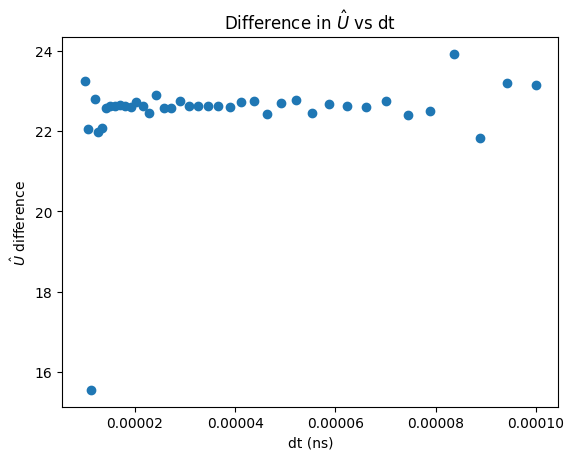

In [46]:

# Plot results
fig = plt.figure()
plt.scatter(dt_list, errors)
# The correct way to set the x-axis scale is on the main plot object:
# plt.xscale('log') 
plt.xlabel('dt (ns)')
plt.ylabel('$\hat{U}$ difference')
plt.title('Difference in $\hat{U}$ vs dt')
plt.show() # Added plt.show() to display the plot

    


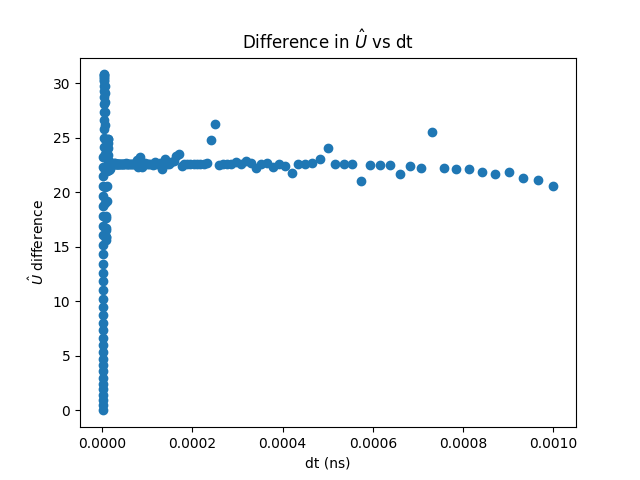

## What I learned

* You can force scipy to use a desired step size by making the tolerance high and using the max_step parameter
* You can also fix the step size by monkey patching the scipy OdeSolver class
* All seem to produce the same result when using the same number of steps
* The handmade 4th order Runge-Kutta is slower than the monkey patched scipy RK45 and they produce the same result 
* If we are using the 